In [1]:
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

import shapely
import shapely.geometry
from PIL import ImageFont, ImageDraw, Image

dev


In [2]:
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)

In [3]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [4]:
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [54]:
foods = read_sql('foods_prompted')
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()


In [55]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [56]:
food_clips = series2tensor(foods['clip'])

In [57]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [58]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15.00, 15.0]
plt.rcParams["figure.autolayout"] = True

In [173]:
url = 'https://image.shutterstock.com/z/stock-photo-healthy-salad-bowl-with-quinoa-tomatoes-chicken-avocado-lime-and-mixed-greens-lettuce-parsley-521741356.jpg'
image = get_image_from_url(url)
image = crop_image_to_square(image)
total_size = image.size[0]*image.size[1]

In [217]:
thershold = 0.0003
params = {'url':url,'thershold':thershold}
boxes,mask = requests.post('http://127.0.0.1:8185/get_boxes/?',params = params).json()
mask = np.array(mask)

In [268]:
boxes_arr= []
for b in  boxes:
    b = [int(bb) for bb in b]
    box   = np.zeros(image.size)
    box  [b[1]:b[3],b[0]:b[2]] = 1
    boxes_arr.append(box)
boxes_arr = np.stack(boxes_arr)

boxes_arr = boxes_arr*mask.T

In [269]:
box_areas = boxes_arr.sum(axis=(1,2))

In [270]:
sorted_index = pd.Series(box_areas).sort_values(ascending = False).index.tolist()

In [271]:
boxes_arr = boxes_arr[sorted_index,:,:]

In [272]:
box_areas = box_areas[sorted_index]

In [273]:
overlap_deleted = boxes_arr.copy()

In [274]:
for n in range(1,boxes_arr.shape[0]):
    size = box_areas[n-1].round(-3)
    overlap = (boxes_arr[n-1,:,:]*boxes_arr[n,:,:]).sum().round(-3)
    if size == overlap:
        overlap_deleted = np.delete(overlap_deleted,n,0)
boxes_arr = overlap_deleted

IndexError: index 64 is out of bounds for axis 0 with size 64

In [276]:
overlap_deleted.shape

(64, 1102, 1102)

In [ ]:
box_areas

In [213]:
overlap_deleted.sum(axis=(1,2))

array([562693., 288342., 188355., 463646., 463646., 442887., 430154.,
        96628., 368137.,   8785.,  11538., 274559., 274559., 274559.,
       254096., 155270., 208134., 208134., 208134., 177970., 177970.,
       177970., 177970., 176102., 176102., 176102., 176102., 176462.,
       165820., 143863., 143863., 143863., 143863., 135775., 135775.,
       135775., 135775., 113408.,  68875.,  68875., 118037., 118037.,
       118037., 118037., 118037.,  99150.,  99150.,  99150.,  99150.,
        99150.,  92609.,  92609.,  91872.,  91872.,  87568.,  72077.,
        72077.,  62101.,  62101.,  62101.,  62101.,  61823.,  66164.,
        38370.,  42873.,  25100.,  37430.,  37233.])

In [175]:
df = pd.DataFrame()
df['area'] = [box_area(box) for box in boxes]
df['boxes'] = boxes
df = df.reset_index()

In [177]:
df = df[df['area']>30000]
df = df.sort_values('area',ascending = False)
df = df.reset_index(drop=True).reset_index()
df = df.rename(columns = {'level_0':'box_area_rank'})
# df = df.sort_values('box_area_rank',ascending = False)
df['boxes'] = df['boxes'].apply(lambda b:[int(bb) for bb in b])

In [ ]:
pd.set

In [178]:
df

,box_area_rank,index,area,boxes
0,0,12,1.189525e+06,"[0, 10, 1100, 1090]"
1,1,64,7.277505e+05,"[0, 425, 1100, 1086]"
2,2,67,6.609604e+05,"[492, 8, 1105, 1088]"
3,3,53,5.694787e+05,"[0, 97, 713, 897]"
4,4,31,5.694787e+05,"[0, 97, 713, 897]"
...,...,...,...,...
69,69,78,4.560174e+04,"[0, 1, 158, 289]"
70,70,94,4.517282e+04,"[59, 203, 265, 422]"
71,71,0,3.754109e+04,"[235, 409, 426, 606]"
72,72,85,3.717661e+04,"[236, 409, 425, 606]"


In [140]:
it = df[['box_area_rank','boxes']].iterrows()

In [142]:
row = next(it)
row = row[1]

In [215]:
photo_id = url.split('/')[-1]
urls = []
for d in df[['index','boxes']].to_dict('records'):
    id,box = d.values()
    urls.append(f'https://glovo.away.guru/fragment_reference_images/{photo_id}_{id}.jpg')
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df = clip_df.reset_index(drop = True)[['description','category','energy','protein','carb','fat','score']]

In [118]:
df = df.join(clip_df)
df = df[df['score']>0.24]

In [120]:
arrays= []
for row in df[['box_area_rank','energy','boxes']].iterrows():
    
    row = row[1]
    b = row['boxes']
    rank   = np.zeros(image.size)
    rank  [b[1]:b[3],b[0]:b[2]] = row['box_area_rank']
    
    energy = np.zeros(image.size)
    energy  [b[1]:b[3],b[0]:b[2]]= row['energy']
    
    row_array = np.stack([rank,energy])
    arrays.append(row_array)
arrays = np.stack(arrays)
arrays = arrays*mask.T

In [121]:
classes =  arrays[:,0,:,:].max(0)
df_count_classes = df[['box_area_rank','description']].set_index('box_area_rank').reindex(classes.reshape(classes.shape[0]*classes.shape[0]))
df_count_classes = df_count_classes.dropna().reset_index().groupby('description').count().sort_values('box_area_rank',ascending = False).head(20)
df_count_classes['%'] = (df_count_classes['box_area_rank']/df_count_classes['box_area_rank'].sum()).round(2)
r = df_count_classes[['%']].join(df.drop_duplicates('description').set_index('description')[['category','energy','protein','carb','fat']])
r

,%,category,energy,protein,carb,fat
description,,,,,,
"Chicken breast, baked, broiled, or roasted, skin eaten, from raw",0.55,"Chicken, whole pieces",192.0,26.25,0.00,8.80
"Quinoa, no added fat",0.15,"Pasta, noodles, cooked grains",120.0,4.38,21.21,1.91
"Avocado, raw",0.11,Other vegetables and combinations,160.0,2.00,8.53,14.66
"Chicken or turkey garden salad with cheese, chicken and/or turkey, cheese, lettuce and/or greens, tomato and/or carrots, other vegetables, no dressing",0.07,Poultry mixed dishes,91.0,10.40,2.80,4.52
"Avocado, for use on a sandwich",0.05,Vegetables on a sandwich,160.0,2.00,8.53,14.66
"Lime, raw",0.03,Citrus fruits,30.0,0.70,10.54,0.20
Chicken or turkey salad with nuts and/or fruits,0.02,Poultry mixed dishes,230.0,12.51,5.95,17.85
"Buckwheat groats, fat added",0.01,"Pasta, noodles, cooked grains",112.0,3.22,18.99,3.34
"Chicken or turkey caesar garden salad, chicken and/or turkey, lettuce, tomato, cheese, no dressing",0.00,Poultry mixed dishes,60.0,8.68,2.71,1.95


In [128]:
desc = """Chicken or turkey salad with nuts and/or fruits"""
df[df['description'] == desc]['index']

1     51
3     34
25     7
29    49
30     4
34    44
Name: index, dtype: int64

(377, 332)


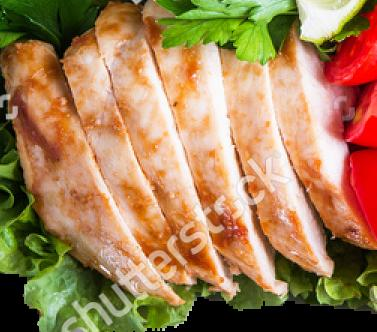

In [133]:
i = get_image_from_url(urls[49])
print(i.size)
i

In [124]:
colories_tensor = np.where((arrays[:,0,:,:] == arrays[:,0,:,:].max(0)),arrays[:,1,:,:],0).max(0)
colories_tensor[colories_tensor!=0].mean()

129.16958944168545

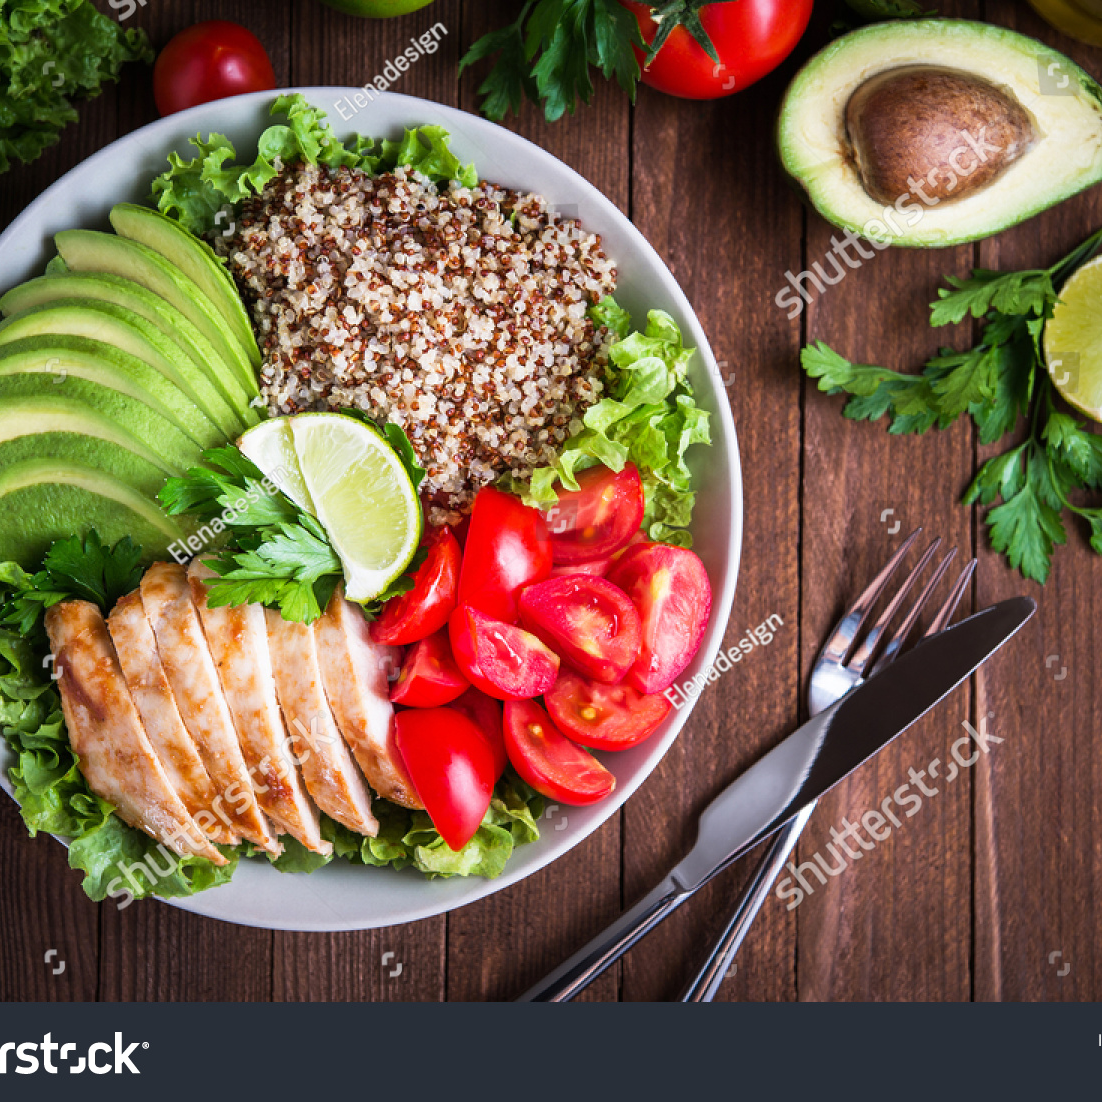

In [125]:
image

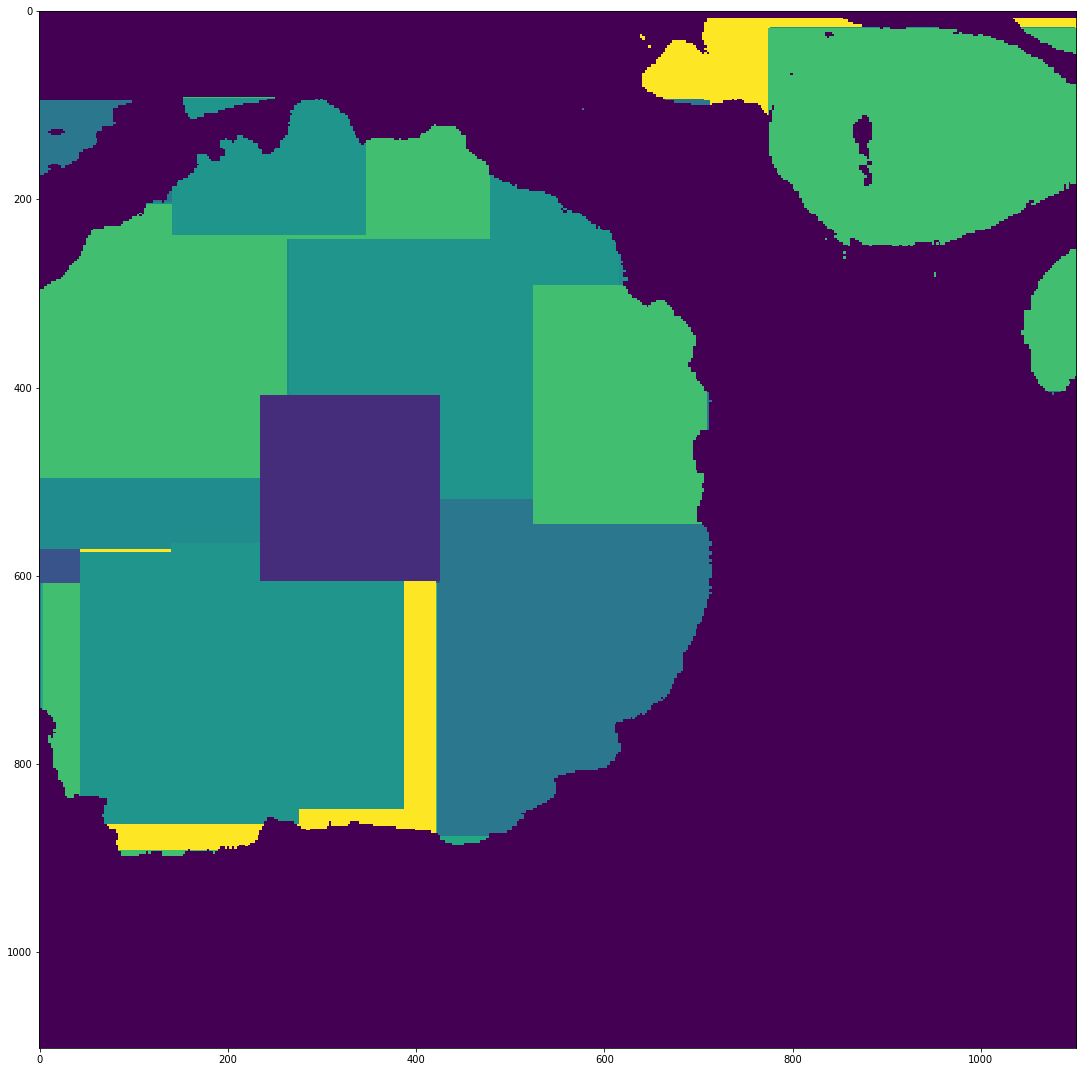

In [130]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colories_tensor, interpolation='none', alpha=1)